<a href="https://colab.research.google.com/github/nabilaashari/Tugas_DL/blob/main/Tugas_DL%20/Tugas_DL_TM4/batchsize64andlearningrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-expression-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F99505%2F234911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T014634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D232bd9f2e1a69644d5e0a6a783ce2405f0e9ad6de660f13621ebb729e94c105167238879d0db698a97f0cf5530f6955e98b84ea86df0f574c34522d411ea1003e8a8eab3d2c49cf871dc21d237a03de8a4aee58a3a35b9e17674f21878d7e35a0a7daa0f37aeb9a5362023d0e9ed5e4ad960ddbf8aa2ff1b5020b1fc70b523c79355476dc0b02270addae26b5995e758dc373fd2d31abc6b3e5d2cc534c2fc23500aaaca7794c186cfe42bb43cec73fa046d73b19426a489ada9aaf9da0a9ee7a2ed0d5a1854e2813b5f4f0cd9b4eafd9460547136d1afd18f30d0e18d714fcd056ac36a0d7631bbe9096a161f26bbeef50c4b6f55a4d8959ca4c11dd2de0c0b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 126358582 bytes downloaded
Downloaded and uncompressed: face-expression-recognition-dataset
Data source import complete.


# Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

# Displaying Images

In [4]:
picture_size = 48
folder_path = "../input/face-expression-recognition-dataset/images/"

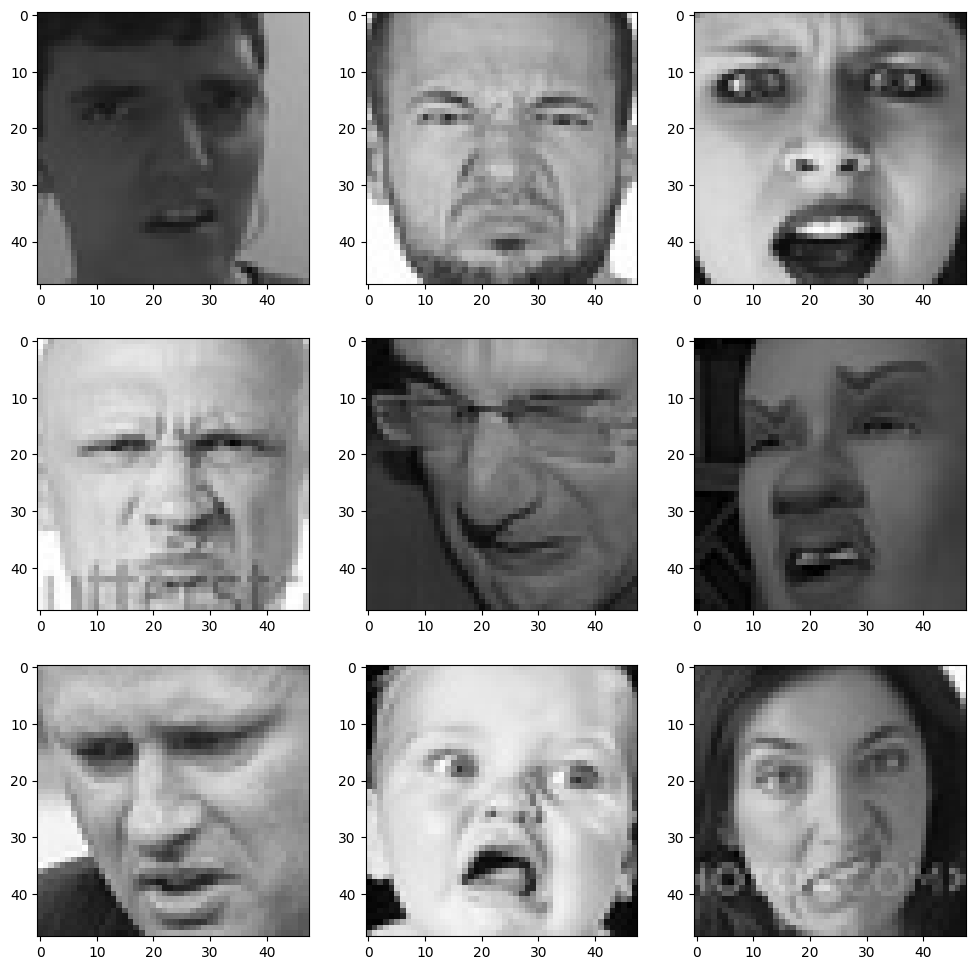

In [5]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

# Making Training and Validation Data

In [12]:
batch_size  = 64

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [13]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

# Fitting the Model with Training and Validation Data

In [15]:
epochs = 50

from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
  1/450 [..............................] - ETA: 43s - loss: 2.2927 - accuracy: 0.2188

<ipython-input-15-803ccc8973de>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


449/450 [============================>.] - ETA: 0s - loss: 1.7502 - accuracy: 0.3244

450/450 [==============================] - 18s 41ms/step - loss: 1.7494 - accuracy: 0.3247 - val_loss: 2.2841 - val_accuracy: 0.3119
Epoch 2/50
450/450 [==============================] - ETA: 0s - loss: 1.3886 - accuracy: 0.4653

450/450 [==============================] - 19s 42ms/step - loss: 1.3886 - accuracy: 0.4653 - val_loss: 1.2652 - val_accuracy: 0.5125
Epoch 3/50
449/450 [============================>.] - ETA: 0s - loss: 1.2425 - accuracy: 0.5246

450/450 [==============================] - 18s 40ms/step - loss: 1.2423 - accuracy: 0.5248 - val_loss: 1.3965 - val_accuracy: 0.4388
Epoch 4/50
450/450 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.5549

450/450 [==============================] - 19s 41ms/step - loss: 1.1732 - accuracy: 0.5549 - val_loss: 1.2406 - val_accuracy: 0.5253
Epoch 5/50
449/450 [============================>.] - ETA: 0s - loss: 1.1114 - accuracy: 0.5786

450/450 [==============================] - 18s 41ms/step - loss: 1.1120 - accuracy: 0.5785 - val_loss: 1.1415 - val_accuracy: 0.5609
Epoch 6/50
449/450 [============================>.] - ETA: 0s - loss: 1.0590 - accuracy: 0.5988

450/450 [==============================] - 19s 43ms/step - loss: 1.0589 - accuracy: 0.5987 - val_loss: 1.1417 - val_accuracy: 0.5655
Epoch 7/50
449/450 [============================>.] - ETA: 0s - loss: 1.0146 - accuracy: 0.6163

450/450 [==============================] - 18s 40ms/step - loss: 1.0148 - accuracy: 0.6163 - val_loss: 1.1600 - val_accuracy: 0.5494
Epoch 8/50
450/450 [==============================] - ETA: 0s - loss: 0.9709 - accuracy: 0.6317

450/450 [==============================] - 18s 41ms/step - loss: 0.9709 - accuracy: 0.6317 - val_loss: 1.1430 - val_accuracy: 0.5729
Epoch 9/50
449/450 [============================>.] - ETA: 0s - loss: 0.9245 - accuracy: 0.6515

450/450 [==============================] - 18s 40ms/step - loss: 0.9239 - accuracy: 0.6517 - val_loss: 1.0532 - val_accuracy: 0.6061
Epoch 10/50
450/450 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6702

450/450 [==============================] - 18s 40ms/step - loss: 0.8815 - accuracy: 0.6702 - val_loss: 1.3177 - val_accuracy: 0.5173
Epoch 11/50
449/450 [============================>.] - ETA: 0s - loss: 0.8292 - accuracy: 0.6890

450/450 [==============================] - 19s 41ms/step - loss: 0.8296 - accuracy: 0.6890 - val_loss: 1.1748 - val_accuracy: 0.5696
Epoch 12/50
449/450 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.7040

450/450 [==============================] - 18s 40ms/step - loss: 0.7860 - accuracy: 0.7040 - val_loss: 1.1583 - val_accuracy: 0.5865
Epoch 13/50
449/450 [============================>.] - ETA: 0s - loss: 0.7335 - accuracy: 0.7283

450/450 [==============================] - 18s 41ms/step - loss: 0.7335 - accuracy: 0.7284 - val_loss: 1.1638 - val_accuracy: 0.5767
Epoch 14/50
449/450 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.7444

450/450 [==============================] - 18s 40ms/step - loss: 0.6851 - accuracy: 0.7445 - val_loss: 1.2325 - val_accuracy: 0.5699
Epoch 15/50
450/450 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.7666

450/450 [==============================] - 18s 41ms/step - loss: 0.6337 - accuracy: 0.7666 - val_loss: 1.1701 - val_accuracy: 0.6065
Epoch 16/50
450/450 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.7801

450/450 [==============================] - 18s 40ms/step - loss: 0.5912 - accuracy: 0.7801 - val_loss: 1.1930 - val_accuracy: 0.6055
Epoch 17/50
449/450 [============================>.] - ETA: 0s - loss: 0.5413 - accuracy: 0.8003

450/450 [==============================] - 19s 41ms/step - loss: 0.5414 - accuracy: 0.8002 - val_loss: 1.2051 - val_accuracy: 0.6128
Epoch 18/50
450/450 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.8131

450/450 [==============================] - 18s 41ms/step - loss: 0.5041 - accuracy: 0.8131 - val_loss: 1.2447 - val_accuracy: 0.6128
Epoch 19/50
450/450 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.8289

450/450 [==============================] - 18s 40ms/step - loss: 0.4665 - accuracy: 0.8289 - val_loss: 1.3792 - val_accuracy: 0.5923
Epoch 20/50
449/450 [============================>.] - ETA: 0s - loss: 0.4321 - accuracy: 0.8438

450/450 [==============================] - 18s 41ms/step - loss: 0.4321 - accuracy: 0.8437 - val_loss: 1.2130 - val_accuracy: 0.6345
Epoch 21/50
449/450 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.8493

450/450 [==============================] - 18s 41ms/step - loss: 0.4164 - accuracy: 0.8493 - val_loss: 1.2249 - val_accuracy: 0.6200
Epoch 22/50
450/450 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8637

450/450 [==============================] - 19s 41ms/step - loss: 0.3755 - accuracy: 0.8637 - val_loss: 1.3155 - val_accuracy: 0.6266
Epoch 23/50
450/450 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8707

450/450 [==============================] - 19s 42ms/step - loss: 0.3529 - accuracy: 0.8707 - val_loss: 1.3091 - val_accuracy: 0.6260
Epoch 24/50
450/450 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8794

450/450 [==============================] - 18s 41ms/step - loss: 0.3337 - accuracy: 0.8794 - val_loss: 1.4132 - val_accuracy: 0.6078
Epoch 25/50
450/450 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8858

450/450 [==============================] - 18s 41ms/step - loss: 0.3134 - accuracy: 0.8858 - val_loss: 1.5248 - val_accuracy: 0.5911
Epoch 26/50
450/450 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8919

450/450 [==============================] - 18s 40ms/step - loss: 0.3029 - accuracy: 0.8919 - val_loss: 1.3676 - val_accuracy: 0.6345
Epoch 27/50
449/450 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.9004

450/450 [==============================] - 18s 41ms/step - loss: 0.2819 - accuracy: 0.9005 - val_loss: 1.5996 - val_accuracy: 0.6081
Epoch 28/50
449/450 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9019

450/450 [==============================] - 18s 41ms/step - loss: 0.2687 - accuracy: 0.9019 - val_loss: 1.4294 - val_accuracy: 0.6345
Epoch 29/50
450/450 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9090

450/450 [==============================] - 18s 41ms/step - loss: 0.2515 - accuracy: 0.9090 - val_loss: 1.4864 - val_accuracy: 0.6176
Epoch 30/50
449/450 [============================>.] - ETA: 0s - loss: 0.2468 - accuracy: 0.9105

450/450 [==============================] - 18s 40ms/step - loss: 0.2469 - accuracy: 0.9102 - val_loss: 1.8096 - val_accuracy: 0.5639
Epoch 31/50
450/450 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9174

450/450 [==============================] - 19s 42ms/step - loss: 0.2306 - accuracy: 0.9174 - val_loss: 1.5576 - val_accuracy: 0.6105
Epoch 32/50
450/450 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9225

450/450 [==============================] - 18s 41ms/step - loss: 0.2233 - accuracy: 0.9225 - val_loss: 1.8612 - val_accuracy: 0.5589
Epoch 33/50
450/450 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9241

450/450 [==============================] - 18s 41ms/step - loss: 0.2153 - accuracy: 0.9241 - val_loss: 1.5296 - val_accuracy: 0.6339
Epoch 34/50
450/450 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9260

450/450 [==============================] - 18s 41ms/step - loss: 0.2075 - accuracy: 0.9260 - val_loss: 1.5962 - val_accuracy: 0.6183
Epoch 35/50
450/450 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9289

450/450 [==============================] - 18s 40ms/step - loss: 0.2030 - accuracy: 0.9289 - val_loss: 1.6348 - val_accuracy: 0.6354
Epoch 36/50
449/450 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9294

450/450 [==============================] - 19s 42ms/step - loss: 0.1996 - accuracy: 0.9294 - val_loss: 1.7215 - val_accuracy: 0.5994
Epoch 37/50
449/450 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9318

450/450 [==============================] - 18s 40ms/step - loss: 0.1921 - accuracy: 0.9318 - val_loss: 1.7239 - val_accuracy: 0.6365
Epoch 38/50
450/450 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9356

450/450 [==============================] - 19s 41ms/step - loss: 0.1809 - accuracy: 0.9356 - val_loss: 1.6385 - val_accuracy: 0.6511
Epoch 39/50
449/450 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9356

450/450 [==============================] - 18s 40ms/step - loss: 0.1846 - accuracy: 0.9354 - val_loss: 1.6116 - val_accuracy: 0.6428
Epoch 40/50
449/450 [============================>.] - ETA: 0s - loss: 0.1752 - accuracy: 0.9373

450/450 [==============================] - 18s 40ms/step - loss: 0.1753 - accuracy: 0.9372 - val_loss: 1.8048 - val_accuracy: 0.6190
Epoch 41/50
450/450 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9373

450/450 [==============================] - 18s 41ms/step - loss: 0.1731 - accuracy: 0.9373 - val_loss: 1.6666 - val_accuracy: 0.6304
Epoch 42/50
450/450 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9422

450/450 [==============================] - 18s 40ms/step - loss: 0.1662 - accuracy: 0.9422 - val_loss: 1.7128 - val_accuracy: 0.6222
Epoch 43/50
449/450 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9428

450/450 [==============================] - 19s 41ms/step - loss: 0.1627 - accuracy: 0.9428 - val_loss: 1.7490 - val_accuracy: 0.6365
Epoch 44/50
449/450 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9429

450/450 [==============================] - 18s 40ms/step - loss: 0.1612 - accuracy: 0.9429 - val_loss: 1.8321 - val_accuracy: 0.6000
Epoch 45/50
449/450 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9452

450/450 [==============================] - 19s 42ms/step - loss: 0.1572 - accuracy: 0.9452 - val_loss: 1.7898 - val_accuracy: 0.6222
Epoch 46/50
450/450 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9462

450/450 [==============================] - 18s 40ms/step - loss: 0.1515 - accuracy: 0.9462 - val_loss: 1.7359 - val_accuracy: 0.6347
Epoch 47/50
449/450 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9435

450/450 [==============================] - 18s 41ms/step - loss: 0.1579 - accuracy: 0.9435 - val_loss: 1.6812 - val_accuracy: 0.6337
Epoch 48/50
450/450 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9476

450/450 [==============================] - 18s 41ms/step - loss: 0.1496 - accuracy: 0.9476 - val_loss: 1.7178 - val_accuracy: 0.6379
Epoch 49/50
450/450 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9494

450/450 [==============================] - 19s 42ms/step - loss: 0.1478 - accuracy: 0.9494 - val_loss: 1.9609 - val_accuracy: 0.5909
Epoch 50/50
450/450 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9497

450/450 [==============================] - 18s 41ms/step - loss: 0.1402 - accuracy: 0.9497 - val_loss: 1.7464 - val_accuracy: 0.6445


# Saving the Model

In [9]:
model.save_weights("./model.h5")

# Plotting Accuracy & Loss

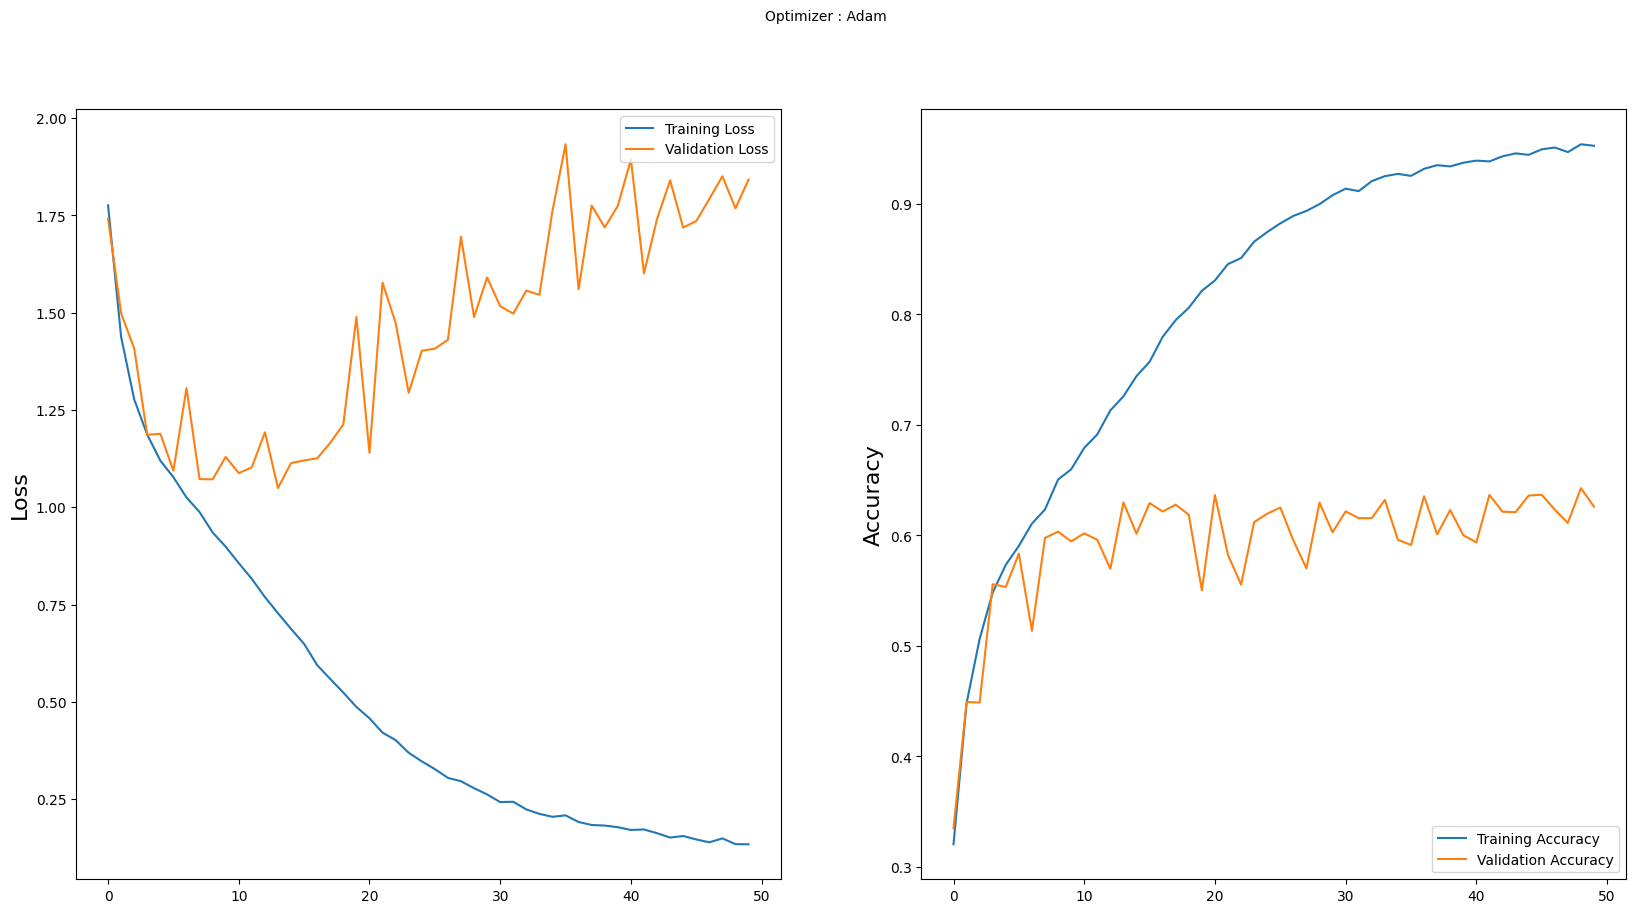

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()